In [23]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer
from sklearn.metrics import f1_score

In [2]:
### Constants
seed = 69
cv_size = .3

In [3]:
train = pd.read_csv("data/Train.csv", encoding="ISO-8859-1")
test = pd.read_csv("data/Test.csv", encoding="ISO-8859-1")

In [4]:
train.head()

,sessionId,custId,date,year,month,channelGrouping,visitStartTime,visitNumber,timeSinceLastVisit,browser,...,adwordsClickInfo.page,adwordsClickInfo.slot,adwordsClickInfo.gclId,adwordsClickInfo.adNetworkType,adwordsClickInfo.isVideoAd,hits,pageviews,bounces,newVisits,revenue
0,100000110,1,2016-10-29,2016,10,Social,1477775021,1,0,Chrome,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0
1,400000140,4,2016-09-04,2016,9,Social,1473037945,1,0,Safari,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0
2,500000150,5,2017-07-17,2017,7,Organic Search,1500305542,1,0,Chrome,...,NaN,NaN,NaN,NaN,NaN,5,5.0,NaN,1.0,0.0
3,500000250,5,2017-07-17,2017,7,Organic Search,1500322111,2,16569,Chrome,...,NaN,NaN,NaN,NaN,NaN,3,3.0,NaN,NaN,0.0
4,700000170,7,2016-08-22,2016,8,Social,1471890172,1,0,Safari,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0


In [5]:
train.columns

Index(['sessionId', 'custId', 'date', 'year', 'month', 'channelGrouping',
       'visitStartTime', 'visitNumber', 'timeSinceLastVisit', 'browser',
       'operatingSystem', 'isMobile', 'deviceCategory', 'continent',
       'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain',
       'topLevelDomain', 'campaign', 'source', 'medium', 'keyword',
       'isTrueDirect', 'referralPath', 'adContent', 'adwordsClickInfo.page',
       'adwordsClickInfo.slot', 'adwordsClickInfo.gclId',
       'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.isVideoAd', 'hits',
       'pageviews', 'bounces', 'newVisits', 'revenue'],
      dtype='object')

In [6]:
train.shape

(83578, 38)

In [7]:
train.iloc[2]

sessionId                                500000150
custId                                           5
date                                    2017-07-17
year                                          2017
month                                            7
channelGrouping                     Organic Search
visitStartTime                          1500305542
visitNumber                                      1
timeSinceLastVisit                               0
browser                                     Chrome
operatingSystem                            Windows
isMobile                                         0
deviceCategory                             desktop
continent                                 Americas
subContinent                      Northern America
country                                     Canada
region                                         NaN
metro                                          NaN
city                                           NaN
networkDomain                  

In [8]:
min(train["revenue"].values)

0.0

In [9]:
max(train["revenue"].values)

10589.14

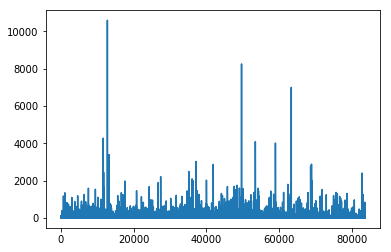

In [10]:
plt.plot(train["revenue"])

In [11]:
X = train.loc[:, train.columns != 'revenue']
y = train["revenue"]

In [13]:
# encode string input values as integers
features = []
encode_cols = ["browser", "operatingSystem", "deviceCategory", "continent", 
              "subContinent", "country", "region", "metro", "city", "medium"]

# encode string input values as integers
encoded_x = None
for i in encode_cols:
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X[i].fillna('0'))
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: ", encoded_x.shape)
# encoded_x = np.array(features)
# encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])

X shape:  (83578, 1167)


In [14]:
other_cols = ["visitNumber", "isMobile", "hits", "pageviews", "bounces", "newVisits"]

In [15]:
X = np.concatenate((X[other_cols].fillna(0), encoded_x), axis=1)

In [27]:
y = Binarizer().transform(y.values.reshape(-1, 1))

In [29]:
print(max(y))
print(min(y))

[1.]
[0.]


In [31]:
print(X.shape)

(83578, 1173)


In [32]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=cv_size, random_state=seed)

In [33]:
print(X_train.shape)
print(X_cv.shape)

(58504, 1173)
(25074, 1173)


In [34]:
print(y_train.shape)
print(y_cv.shape)

(58504, 1)
(25074, 1)


In [35]:
xgtrain = xgb.DMatrix(X_train, y_train)
xgcv = xgb.DMatrix(X_cv, y_cv)

In [36]:
# Specify sufficient boosting iterations to reach a minimum
num_round = 3000

# Leave most parameters as default
param = {'objective': 'binary:logistic',
         'tree_method': 'gpu_hist' # Use GPU accelerated algorithm
         }
bst = xgb.train(param, xgtrain, num_round)

In [ ]:
# model = xgb.XGBClassifier()
# model.fit(X_train, y_train)

In [ ]:
# # specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'binary:logistic'}

# # specify validations set to watch performance
# watchlist = [(xgcv, 'eval'), (xgtrain, 'train')]
# num_round = 2
# bst = xgb.train(param, xgtrain, num_round, watchlist)

In [37]:
bst.save_model('first.model')

In [41]:
pred = bst.predict(xgcv)

In [47]:
bin_pred = Binarizer(threshold=0.5).transform(pred.reshape(-1,1))

In [48]:
print(pred)
print(bin_pred)

[5.4681923e-02 2.9160088e-10 4.4355215e-06 ... 1.9818206e-06 8.4717786e-01
 5.0035766e-08]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


In [51]:
f1 = f1_score(y_cv, bin_pred)
f1

0.6406712734452122

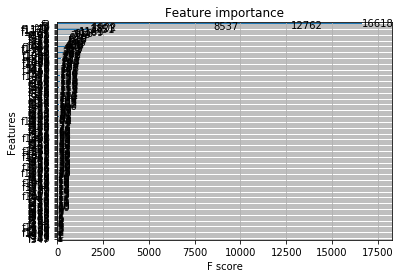

In [53]:
xgb.plot_importance(bst)

In [52]:
# use below for later - scales test

In [38]:
# encode string input values as integers
features = []
encoded_x = None
for i in encode_cols:
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(test[i].fillna('0'))
	feature = feature.reshape(test.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
print("X shape: ", encoded_x.shape)
# encoded_x = np.array(features)
# encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])
X = np.concatenate((test[other_cols].fillna(0), encoded_x), axis=1)

X shape:  (56208, 1049)
